In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os


## Spec Sample

In [2]:
db=DBBase()
schema = "des_dr2"  
tablename = "des_dr2.public_pz_training_set"

```sql

SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4


```



In [70]:

query = 'SELECT * FROM des_dr2.public_pz_training_set WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4'



In [71]:
df_origin = db.fetchall_df(query)

In [72]:
g = df_origin['mag_auto_g_dered']
r = df_origin['mag_auto_r_dered']
i = df_origin['mag_auto_i_dered']
z = df_origin['mag_auto_z_dered']
y = df_origin['mag_auto_y_dered']

df_origin['g-r'] = g-r
df_origin['r-i'] = r-i
df_origin['i-z'] = i-z
df_origin['z-y'] = z-y

In [224]:
spec_sample = df_origin


### Selecting catalogs 

In [293]:
mask1 = (spec_sample['survey'] == 'VIPERS')
mask2 = (spec_sample['survey'] == 'VVDS')
mask3 = (spec_sample['survey'] == 'GAMA')
#mask4 = (spec_sample['survey'] == 'PRIMUS')
new_sample = spec_sample[mask1 | mask2 | mask3]

In [225]:
spec_sample

,coadd_object_id,ra,dec,z,err_z,flag_des,survey,flag_survey,mag_auto_g_dered,mag_auto_r_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
0,1011353819,-7.322178,-41.760673,0.2143,99.0,4,2DF,4.0,18.490623,17.264482,...,16.396919,0.004156,0.002004,0.002048,0.002808,0.007311,1.226141,0.424185,0.308693,0.134686
1,1012577456,-7.396057,-41.669178,0.0867,99.0,4,2DF,4.0,18.502615,18.069166,...,17.689028,0.002561,0.002389,0.002843,0.004955,0.013531,0.433449,0.204481,0.124683,0.050974
2,1012581210,-7.215947,-41.707007,0.0937,99.0,4,2DF,4.0,19.023310,18.133617,...,17.351370,0.003100,0.001907,0.002012,0.003469,0.009423,0.889692,0.382782,0.285587,0.113878
3,1012565977,-7.202299,-41.553470,0.1886,99.0,3,2DF,3.0,18.697731,17.617779,...,16.844101,0.004236,0.002269,0.002361,0.003703,0.009919,1.079952,0.368628,0.286850,0.118200
4,1012559214,-7.295955,-41.483863,0.0425,99.0,4,2DF,4.0,18.547184,18.249432,...,18.044237,0.004910,0.004967,0.007760,0.014178,0.040168,0.297752,0.041296,0.132263,0.031635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550740,1094705834,10.809956,-28.676726,0.2050,99.0,3,2DF,3.0,19.033121,18.124178,...,17.400072,0.004308,0.002549,0.003320,0.003835,0.012097,0.908943,0.359520,0.268852,0.095734
550741,1109801032,13.321570,-28.409708,0.2267,99.0,3,2DF,3.0,18.820835,18.042171,...,17.437681,0.002901,0.001784,0.002128,0.003475,0.011486,0.778664,0.346600,0.185968,0.071922
550742,1101679389,12.074874,-27.474755,0.1179,99.0,4,2DF,4.0,18.700645,18.180710,...,17.712612,0.002716,0.002257,0.003305,0.005420,0.017502,0.519936,0.271894,0.146280,0.049923
550743,1094704530,10.639664,-28.666601,0.1106,99.0,4,2DF,4.0,18.027266,17.167582,...,16.487312,0.002134,0.001255,0.001669,0.002191,0.006536,0.859684,0.342470,0.247906,0.089893


## Table per survey

In [188]:
surveys = set(spec_sample['survey'])
survey=[]
matchings=[]
z_mean=[]
z_max=[]
z_min=[]
for surv in surveys:
    survey.append(surv)
    mask = spec_sample[spec_sample['survey']==surv]
    matchings.append(len(mask))
    z_mean.append(round(np.mean(mask['z']),2))
    z_max.append(round(max(mask['z']),2))
    z_min.append(round(min(mask['z']),2))
    

In [121]:
table = pd.DataFrame({'Catálogo':survey, 'Cruzamentos':matchings, 'z_medio':z_mean, 'z_min':z_min, 'z_max':z_max})

In [122]:
table.sort_values(by='Cruzamentos', ascending = False)

,Catálogo,Cruzamentos,z_medio,z_min,z_max
2,SDSS_DR16,329479,0.57,0.00,2.00
11,2DF,51249,0.13,0.00,3.00
23,VIPERS,44713,0.69,0.04,2.00
3,GAMA,26289,0.22,0.00,0.74
9,2dFLenS,23694,0.35,0.00,4.69
12,WIGGLEZ,15689,0.56,0.00,4.24
22,DEEP2,15305,0.96,0.01,2.16
6,3DHST,10548,1.20,0.01,5.81
1,VVDS,8862,0.64,0.01,4.54
15,CLASH-VLT,5422,0.43,0.02,4.15


In [309]:
len(new_sample[new_sample['z']>0.265])/len(new_sample)

0.5037308295933258

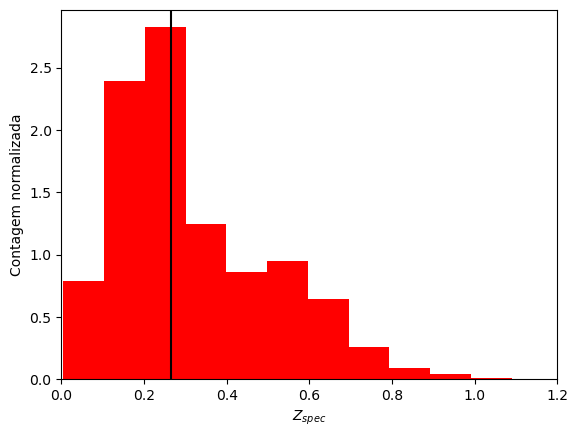

In [310]:
plot_sample = new_sample[new_sample['z']<1.3]
plt.hist(plot_sample['z'],13,density=True,color='red')
plt.xlim(0,1.2)
plt.axvline(0.265,color='black')
plt.xlabel(r'$Z_{spec}$')
plt.ylabel('Contagem normalizada')
plt.show()

## Looking the 12 largest catalogs

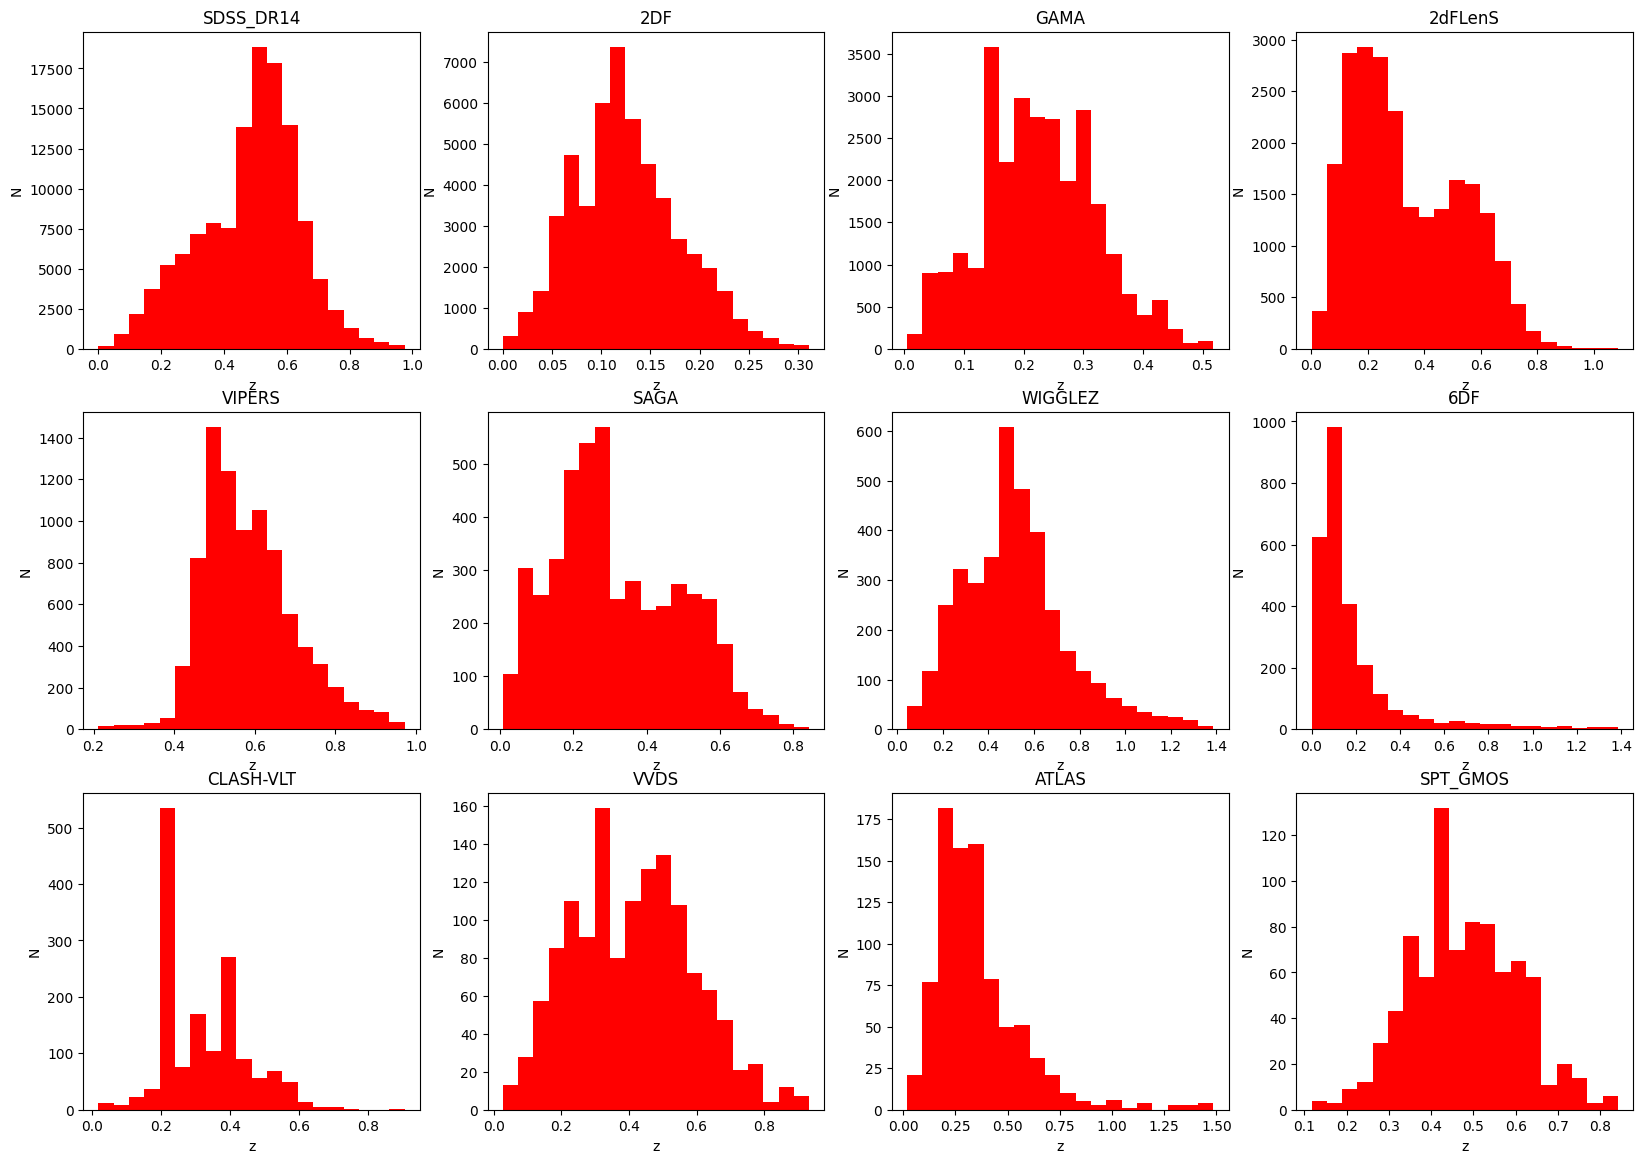

In [341]:
element_count = spec_sample['source'].value_counts().reset_index()
i=1
plt.figure(figsize = (20,14))
for catalog in element_count[:12]['source']:
    redshift = spec_sample[spec_sample['source'] == catalog]['z']
    plt.subplot(3, 4, i)
    plt.xlabel('z')
    plt.ylabel('N')
    std = np.std(redshift)
    mean = np.mean(redshift)
    redshift = redshift[(redshift< mean+3*std) & (redshift> mean-3*std)] #removing outliers with 3 std
    plt.hist(redshift, bins = 20, color = 'red')
    plt.title(catalog)
    i+=1


## View of the sky

In [106]:
! wget https://raw.githubusercontent.com/kadrlica/skymap/master/skymap/data/des-round19-poly.txt  

--2023-11-03 09:12:26--  https://raw.githubusercontent.com/kadrlica/skymap/master/skymap/data/des-round19-poly.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9947 (9.7K) [text/plain]
Saving to: ‘des-round19-poly.txt’

des-round19-poly.tx 100%[===================>]   9.71K  --.-KB/s    in 0s      

2023-11-03 09:12:27 (36.8 MB/s) - ‘des-round19-poly.txt’ saved [9947/9947]



In [107]:
foot_ra, foot_dec = np.loadtxt('des-round19-poly.txt', unpack=True)

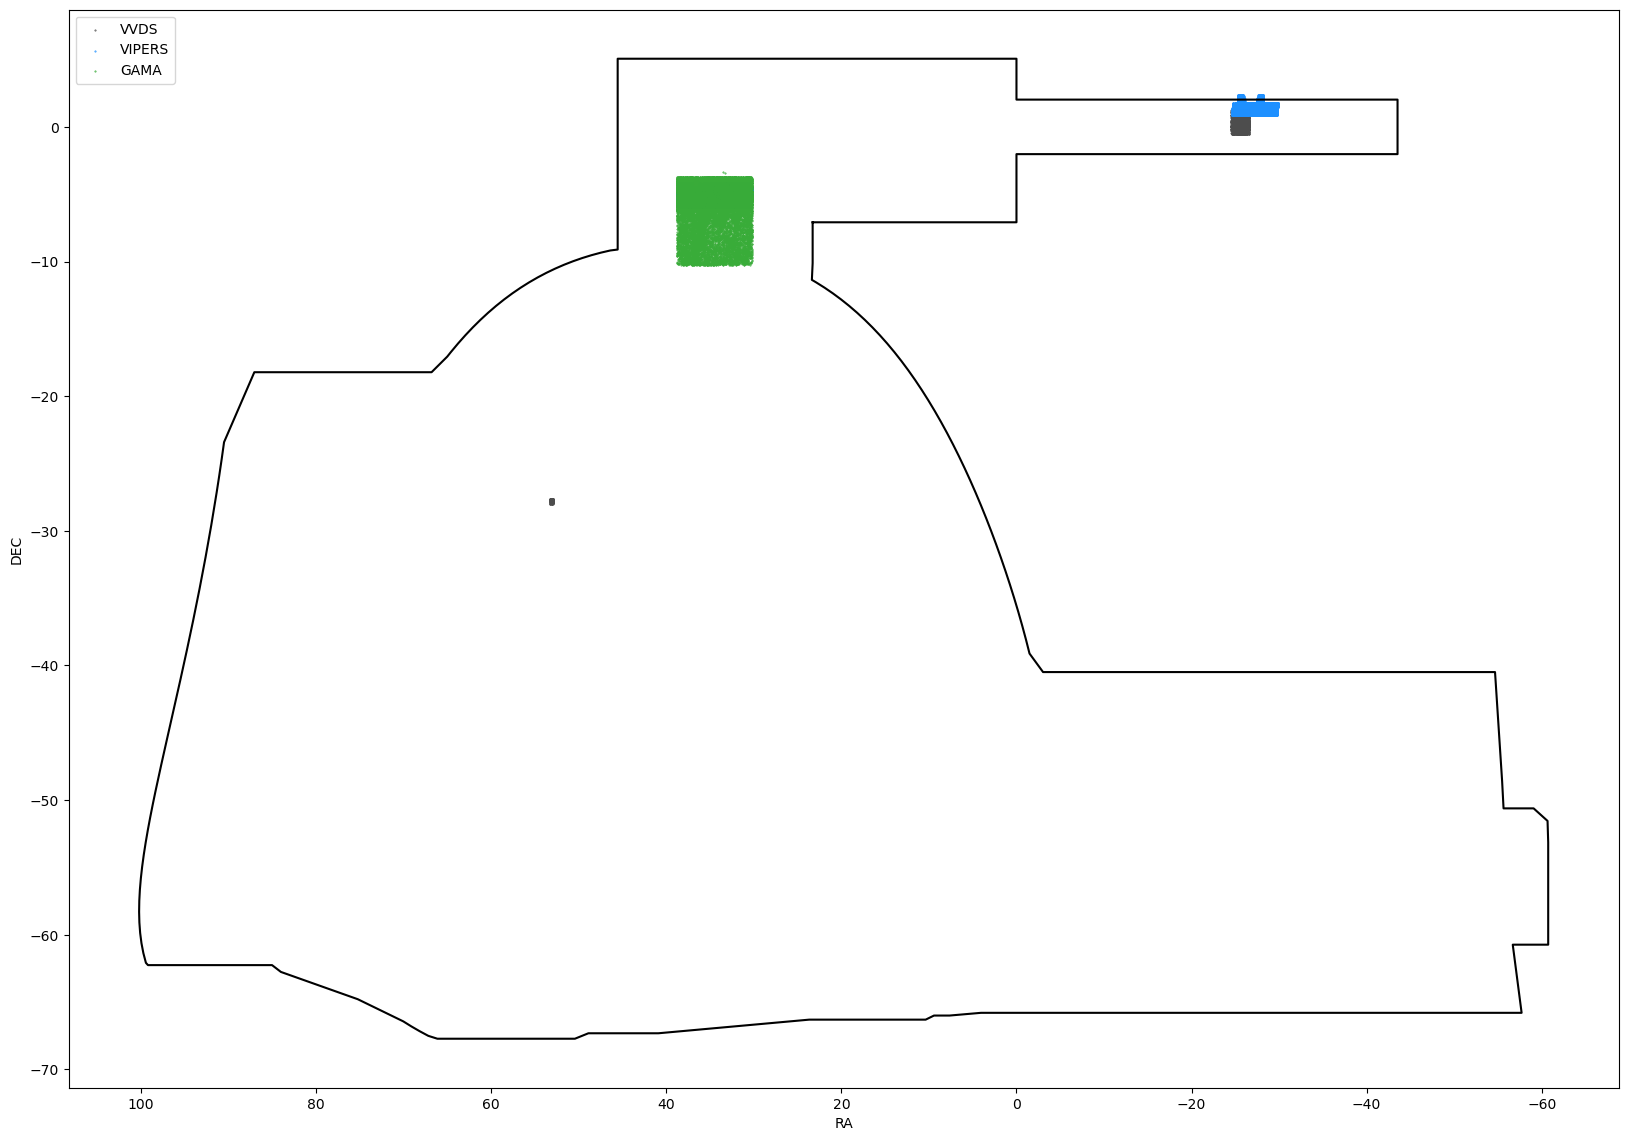

<Figure size 640x480 with 0 Axes>

In [113]:
i=0
colors = [
    '#4D4D4D', '#1E90FF', '#39AC39', '#FF4500', '#8B0000',
    '#9370DB', '#FF1493', '#006400', '#4682B4', '#FF8C00',
    '#DC143C', '#4B0082', '#556B2F', '#2F4F4F', '#00FF7F',
    '#800080', '#FFFF00', '#87CEEB', '#800000', '#00FA9A',
    '#8A2BE2'
]


spec_sample.loc[spec_sample['ra']>150,'ra'] = spec_sample[spec_sample['ra']>150]['ra'] - max(spec_sample['ra']) #For 'tank' format
plt.figure(figsize = (20,14))

for catalog in surveys:
    ra = spec_sample[spec_sample['survey'] == catalog]['ra']
    dec = spec_sample[spec_sample['survey'] == catalog]['dec']
    plt.scatter(ra, dec, color = colors[i], s=0.2 , label = catalog)
    i+=1
plt.plot(58*np.radians(foot_ra), 58*np.radians(foot_dec), '-', color='black')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc = 2)
plt.gca().invert_xaxis()
plt.show()
plt.savefig('Sky-View.png')

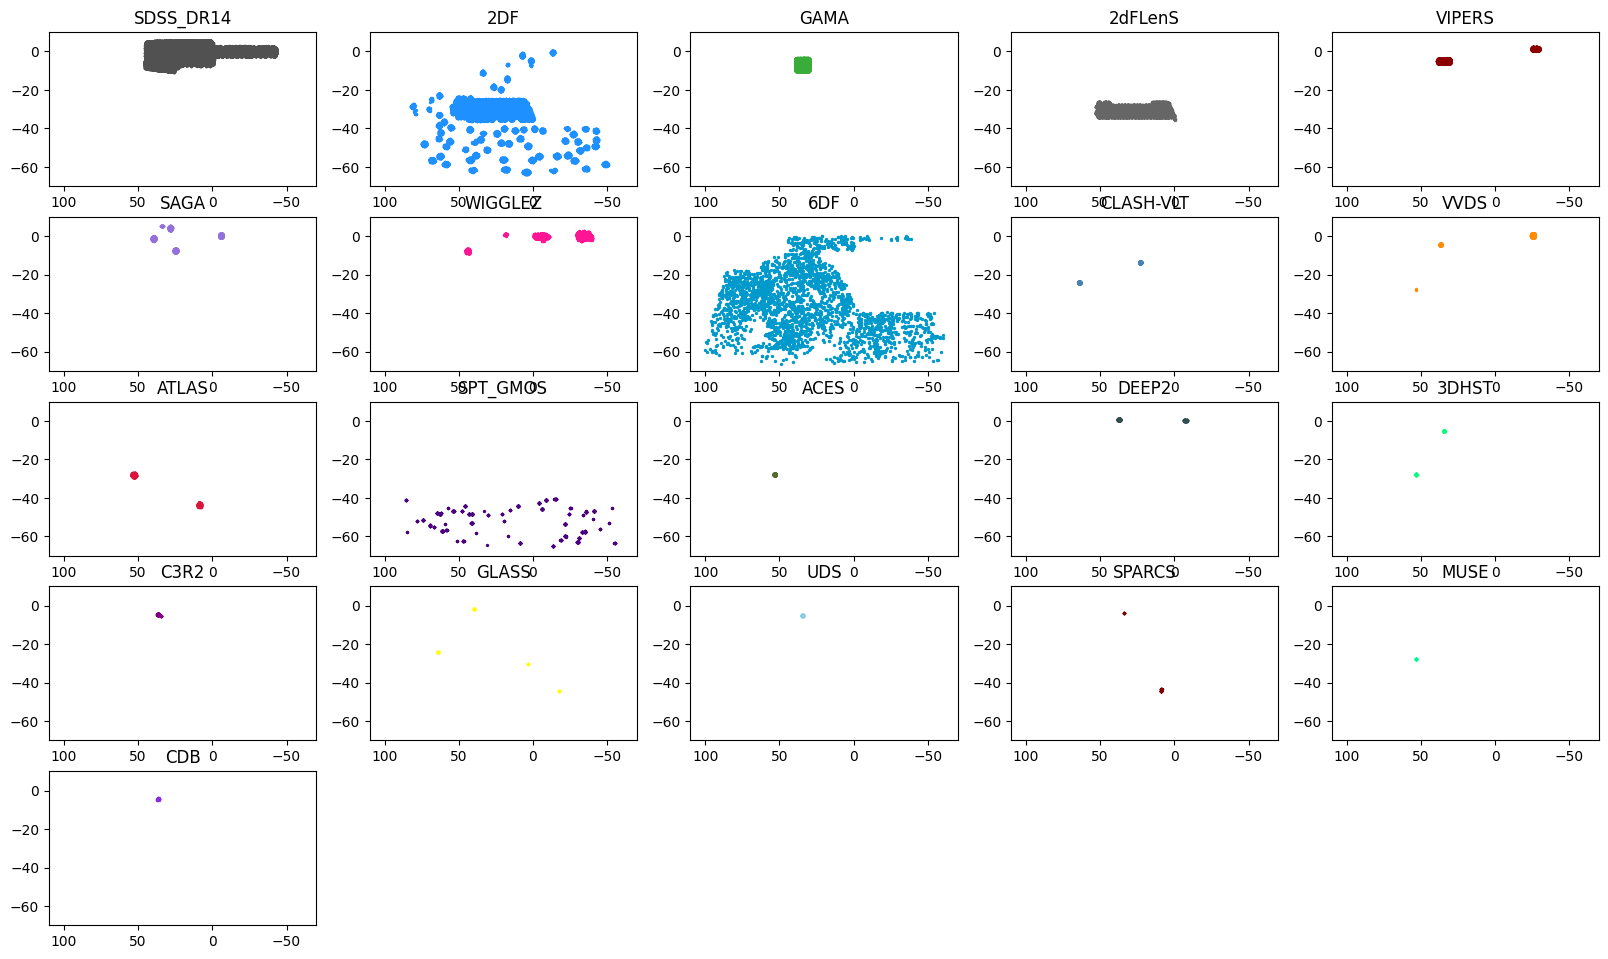

In [355]:
i=0
colors = [
    '#515151', '#1E90FF', '#39AC39', '#666666', '#8B0000',
    '#9370DB', '#FF1493', '#0099CC', '#4682B4', '#FF8C00',
    '#DC143C', '#4B0082', '#556B2F', '#2F4F4F', '#00FF7F',
    '#800080', '#FFFF00', '#87CEEB', '#800000', '#00FA9A',
    '#8A2BE2'
]


plt.figure(figsize = (20,14))
for catalog in element_count['source']:
    ra = spec_sample[spec_sample['source'] ==catalog]['ra']
    dec = spec_sample[spec_sample['source'] ==catalog]['dec']
    plt.subplot(6,5,i+1)
    plt.scatter(ra, dec, color = colors[i], s=2)
    plt.xlim((110,-70))
    plt.ylim((-70,10))
    plt.title(catalog)
    i+=1
plt.show()

# Query for random phot samples

In [16]:
tablename2 = "coadd_objects"

```sql
SELECT ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y, 
FROM des_dr2.coadd_objects 
WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4
AND mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4
ORDER BY RANDOM()
LIMIT 457591;

```

In [17]:


query2 = 'SELECT erra_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 AND mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4 ORDER BY RANDOM() LIMIT 457591;'



In [18]:
%%time
phot_sample = db.fetchall_df(query2)

CPU times: user 6.19 s, sys: 547 ms, total: 6.73 s
Wall time: 41min 28s


# Spec and Phot samples

In [19]:
phot_sample

,erra_image,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,0.344158,353.296287,-63.720504,2,24.812477,24.728436,24.533684,24.451935,99.000000,0.159212,0.190849,0.316175,0.477912,99.000000
1,0.182534,92.246212,-43.241802,2,24.351748,23.591198,23.334475,22.934868,22.835552,0.186489,0.123539,0.178380,0.219192,0.775448
2,0.044309,91.315367,-49.648968,3,22.351542,20.802876,20.313459,20.012133,19.941870,0.037718,0.011799,0.015504,0.018831,0.082163
3,0.240523,69.341168,-48.673490,2,24.868607,25.008471,24.274780,24.480385,24.168421,0.247717,0.362586,0.302873,0.755548,2.160678
4,0.097609,81.195307,-42.022416,3,22.503443,21.530233,21.170383,21.095652,21.278318,0.051315,0.026777,0.033371,0.060028,0.261058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457586,0.191939,71.279868,-62.798774,2,24.071342,23.466057,23.159763,22.853836,25.428181,0.139482,0.106331,0.186429,0.311225,7.921712
457587,0.298875,88.537662,-49.542174,2,25.739710,25.822796,24.827198,24.903347,23.834000,0.246232,0.355668,0.239639,0.534160,0.709140
457588,0.189862,337.923212,-52.218367,3,24.845892,23.377193,22.509766,22.274712,21.793535,0.277663,0.105255,0.076058,0.120016,0.283544
457589,0.281228,68.569762,-39.377484,2,25.815763,25.157600,24.653303,23.644135,99.000000,0.436364,0.282543,0.344497,0.246513,99.000000


In [20]:
gr_spec = spec_sample['mag_auto_g_dered']-spec_sample['mag_auto_r_dered']
ri_spec = spec_sample['mag_auto_r_dered']-spec_sample['mag_auto_i_dered']
iz_spec = spec_sample['mag_auto_i_dered']-spec_sample['mag_auto_z_dered']
gr_phot = phot_sample['mag_auto_g']-phot_sample['mag_auto_r']
ri_phot = phot_sample['mag_auto_r']-phot_sample['mag_auto_i']
iz_phot = phot_sample['mag_auto_i']-phot_sample['mag_auto_z']

## Graphs

NameError: name 'phot_sample' is not defined

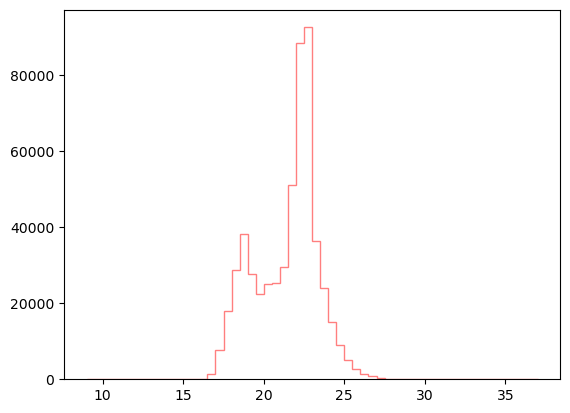

In [114]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(spec_sample[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Spec', alpha = 0.5, edgecolor = "red")
    plt.hist(phot_sample[f'mag_auto_{band}'], histtype='step', bins=bins, label='Phot', alpha = 0.5, edgecolor = "blue")
    plt.title(band)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.show()

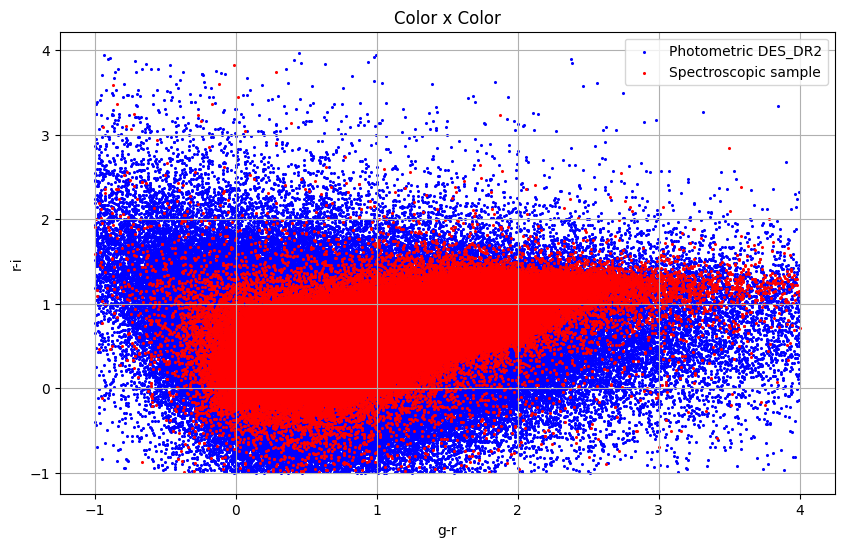

In [107]:
plt.figure(figsize = (10,6))
plt.scatter(gr_phot,ri_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(gr_spec,ri_spec,color = 'red', s=1.5, label = 'Spectroscopic sample')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.legend()
plt.grid()
plt.title('Color x Color')
plt.savefig('cor-cor.png', dpi=300)

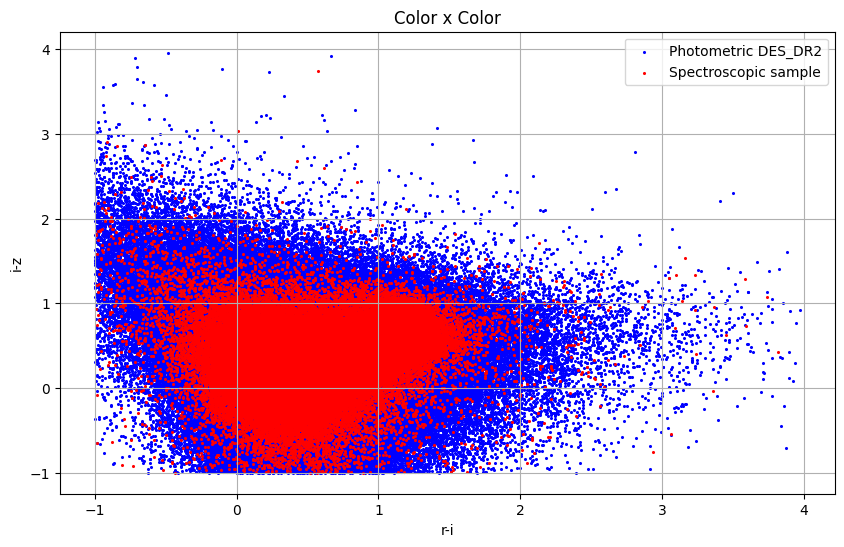

In [108]:
plt.figure(figsize = (10,6))
plt.scatter(ri_phot,iz_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(ri_spec,iz_spec,color = 'red', s=1.5, label = 'Spectroscopic sample')
plt.xlabel('r-i')
plt.ylabel('i-z')
plt.legend()
plt.grid()
plt.title('Color x Color')
plt.savefig('cor-cor2.png', dpi=300)

# Spec analyses

## Mag distribution

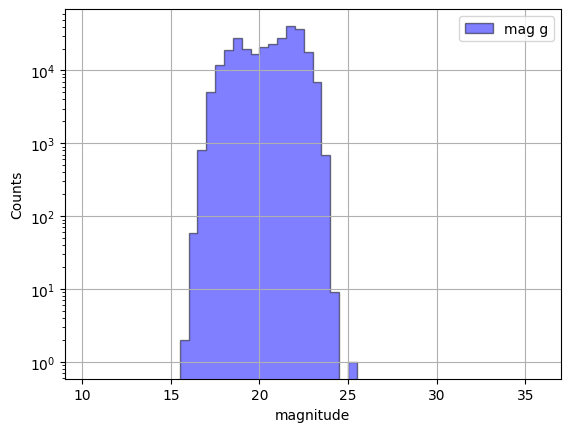

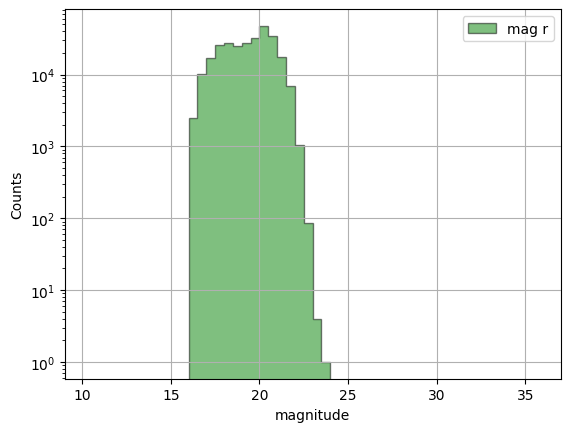

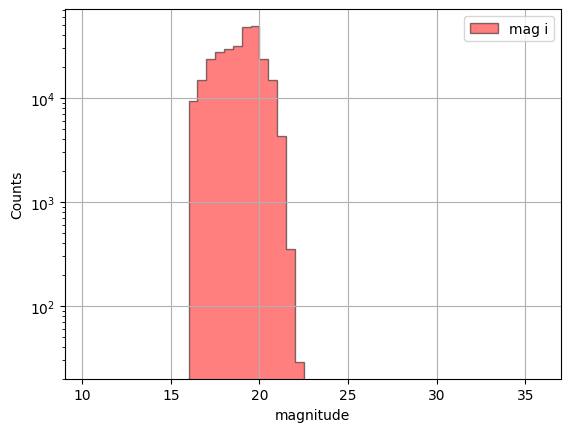

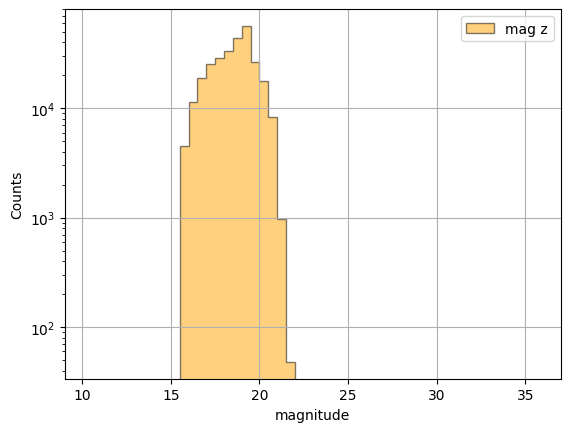

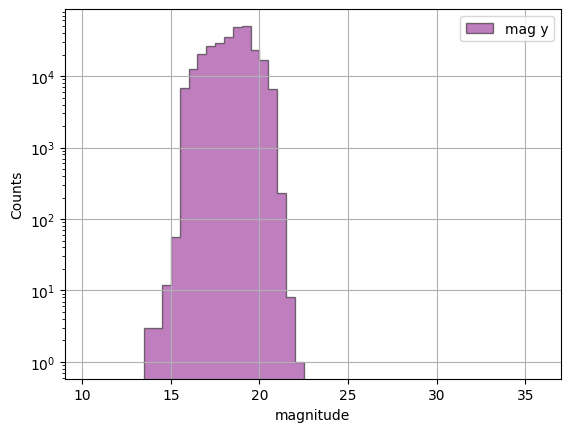

In [90]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(spec_sample[f'mag_auto_{band}_dered'], histtype='stepfilled', bins=bins, label=f'mag {band}', alpha = 0.5, edgecolor = "black", color = color)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

## Diagram mag x color for spec sample

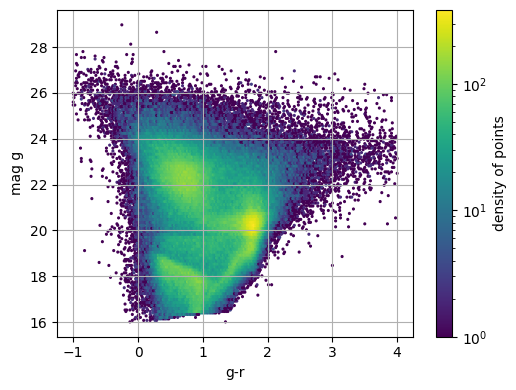

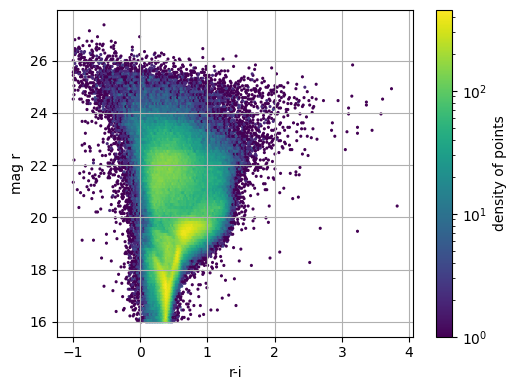

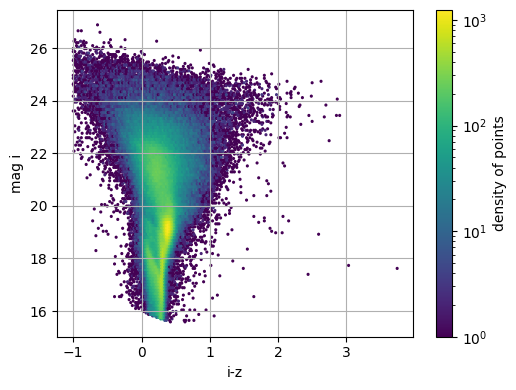

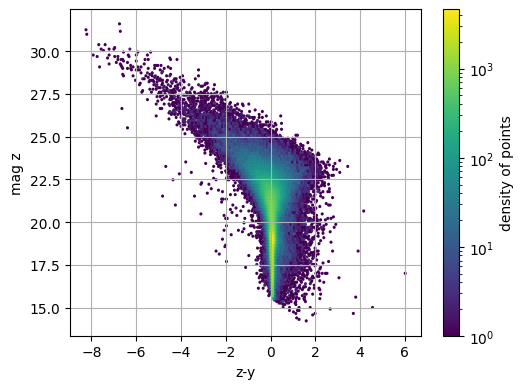

In [48]:
bands = ['g', 'r', 'i', 'z', 'y']
mag_diff = {}
for band,_band in zip(bands, bands[1::]):
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    mag_diff = np.array(spec_sample[f'mag_auto_{band}_dered']) - np.array(spec_sample[f'mag_auto_{_band}_dered'])
    mag = np.array(spec_sample[f'mag_auto_{_band}_dered'])
                   
    mask = (mag>14)&(mag<32)&(mag_diff<10)
    plt.hexbin(mag_diff[mask], mag[mask], None, mincnt=1, cmap='viridis', gridsize=[200,100], bins='log')
    cbar = plt.colorbar(label='density of points')
    plt.ylabel("mag "+band)
    plt.xlabel(f"{band}-{_band}")
    plt.grid(True)
    plt.tight_layout()

## Mag x errors

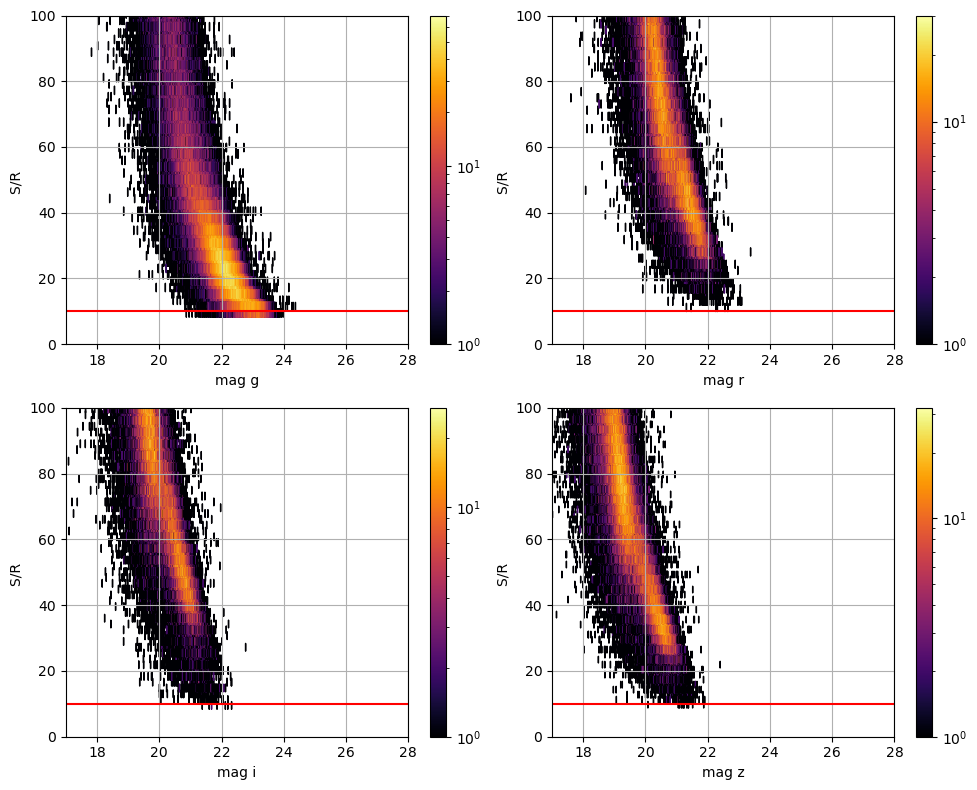

In [182]:
bands = ['g', 'r', 'i', 'z',]# 'y']
j=1
plt.figure(figsize=[10,8])
for i, band in enumerate(bands):

    plt.subplot(2,2,j) 
    mag = np.array(spec_sample[f'mag_auto_{band}_dered'])
    err = np.array(spec_sample[f'magerr_auto_{band}'])
    sn = 1/(10**(0.4*err)-1)
    mask = (mag>14)&(mag<32)&(err<10)
    plt.hexbin(mag[mask],sn[mask] , None, mincnt=1, cmap='inferno', gridsize=[2000,1000], bins='log')
    cbar = plt.colorbar()
    plt.ylabel("S/R ")
    plt.xlabel("mag "+band)
    plt.ylim(0,100)
    plt.xlim(17,28)
    plt.axhline(10, color= 'red')
    plt.grid(True)
    j+=1
    plt.tight_layout()
plt.savefig('/home/iago.dias/TPz_notebooks/errors.png')

## Cutting erros 


In [226]:
spec_sample = spec_sample[(spec_sample['magerr_auto_g']< 0.1086) & (spec_sample['magerr_auto_r']< 0.1086) & (spec_sample['magerr_auto_i']< 0.1086)& (spec_sample['magerr_auto_z']< 0.1086)& (spec_sample['magerr_auto_y']< 0.1086)]


## Studying z-high

In [177]:
zhigh = spec_sample[spec_sample['z']>1.5]


In [178]:
zhigh

,spec_id,z,err_z,flag,source,flag_des,coadd_object_id,ra,dec,mag_auto_g_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
168,125876,1.83305,0.000150,4.0,6DF,4,979602970,-16.798786,-40.792832,18.315022,...,18.300047,0.001176,0.001463,0.001968,0.003835,0.017463,0.017021,0.154215,-0.077066,-0.079195
419,126818,1.98911,0.000150,4.0,6DF,4,1058828972,-6.192905,-40.933154,18.201353,...,17.807959,0.000973,0.001047,0.001152,0.002167,0.008008,0.090328,0.324400,0.004814,-0.026148
633,127044,1.85789,0.000183,3.0,6DF,3,1023884429,-1.996921,-38.395970,17.720102,...,17.520208,0.001585,0.001429,0.001607,0.003319,0.011933,0.064613,0.227011,-0.023373,-0.068357
5407,47279,1.54133,99.000000,3.0,WIGGLEZ,3,936523371,-32.683674,-2.215380,20.753792,...,20.377392,0.011456,0.010917,0.013880,0.026860,0.106991,0.355700,0.149853,-0.039516,-0.089636
8257,49454,2.17508,99.000000,5.0,WIGGLEZ,4,940866518,-31.199138,-0.883445,20.270729,...,20.199808,0.005838,0.007096,0.009546,0.014205,0.064678,-0.073353,0.149014,0.182634,-0.187374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455850,231611,2.19182,0.000150,4.0,6DF,4,1381101258,48.749344,-45.757951,17.784521,...,17.706896,0.000987,0.001047,0.001425,0.002906,0.009418,0.045143,0.030972,0.101099,-0.099588
455862,231595,1.89221,0.000183,3.0,6DF,3,1356884582,44.833835,-45.957073,17.798044,...,17.349108,0.000760,0.000753,0.000972,0.001719,0.005338,0.201878,0.202669,0.043257,0.001133
456963,232488,1.54508,0.000150,4.0,6DF,4,1273776291,35.680693,-40.190228,17.666111,...,17.595453,0.000648,0.000658,0.000903,0.001754,0.007002,0.122974,0.111132,-0.078741,-0.084707
457173,232728,1.62556,0.000150,4.0,6DF,4,1295300599,38.812195,-38.093993,18.045527,...,17.850407,0.001050,0.001029,0.001614,0.002483,0.009425,0.102947,0.129969,0.040419,-0.078215


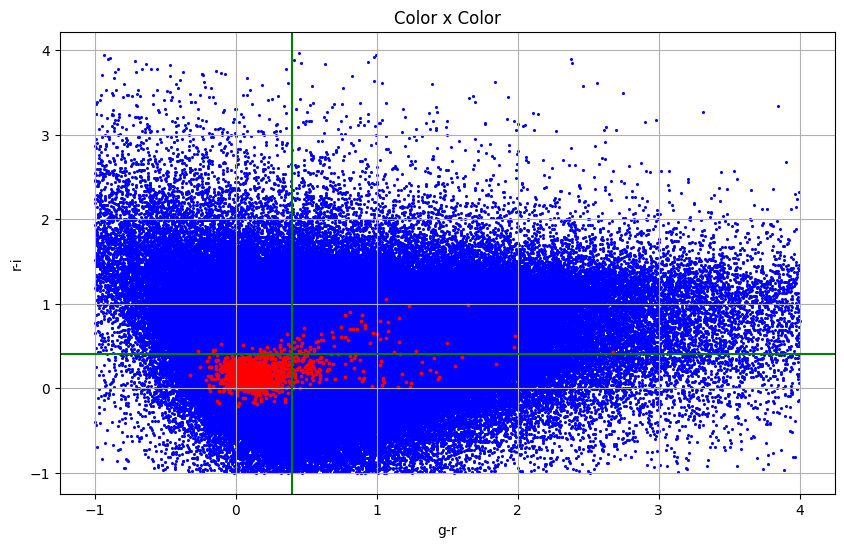

In [179]:
plt.figure(figsize = (10,6))
plt.scatter(gr_phot,ri_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(zhigh['g-r'],zhigh['r-i'],color = 'red', s=3, label = 'Spectroscopic sample')
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.legend()
plt.grid()
plt.title('Color x Color')
plt.axhline(y=0.4, color='green')
plt.axvline(x=0.4, color='green')
#plt.xlim(-0.5,0.5)
#plt.ylim(-1,1)

Text(0.5, 1.0, 'Color x Color')

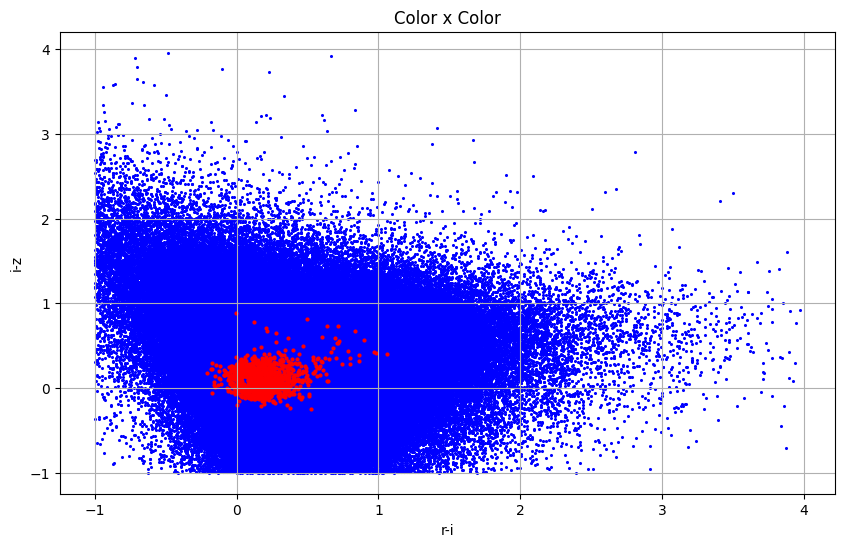

In [180]:
plt.figure(figsize = (10,6))
plt.scatter(ri_phot,iz_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(zhigh['r-i'],zhigh['i-z'],color = 'red', s=4, label = 'Spectroscopic sample')
plt.xlabel('r-i')
plt.ylabel('i-z')
#plt.legend()
plt.grid()
plt.title('Color x Color')

In [181]:
surveys = set(zhigh['source'])
survey=[]
matchings=[]
z_mean=[]
z_max=[]
z_min=[]
for surv in surveys:
    survey.append(surv)
    mask = zhigh[zhigh['source']==surv]
    matchings.append(len(mask))
    z_mean.append(round(np.mean(mask['z']),2))
    z_max.append(round(max(mask['z']),2))
    z_min.append(round(min(mask['z']),2))
    

In [182]:
table = pd.DataFrame({'survey':survey, 'matchings':matchings, 'z_mean':z_mean, 'z_min':z_min, 'z_max':z_max})

In [183]:
table.sort_values(by='matchings', ascending = False)

,survey,matchings,z_mean,z_min,z_max
5,XXL_AAOMEGA,578,2.11,1.50,4.66
12,PANSTARRS,238,2.20,1.50,4.54
0,PRIMUS,151,2.07,1.50,3.87
15,2dFLenS,132,2.18,1.50,4.69
1,6DF,89,1.98,1.51,3.38
8,WIGGLEZ,60,1.85,1.53,4.24
11,STALIN,33,2.12,1.52,3.87
9,ATLAS,28,2.05,1.54,3.20
7,SDSS_DR14,20,1.74,1.53,1.98
10,CLASH-VLT,9,2.21,1.69,4.15


Text(0.5, 1.0, 'Color x Color')

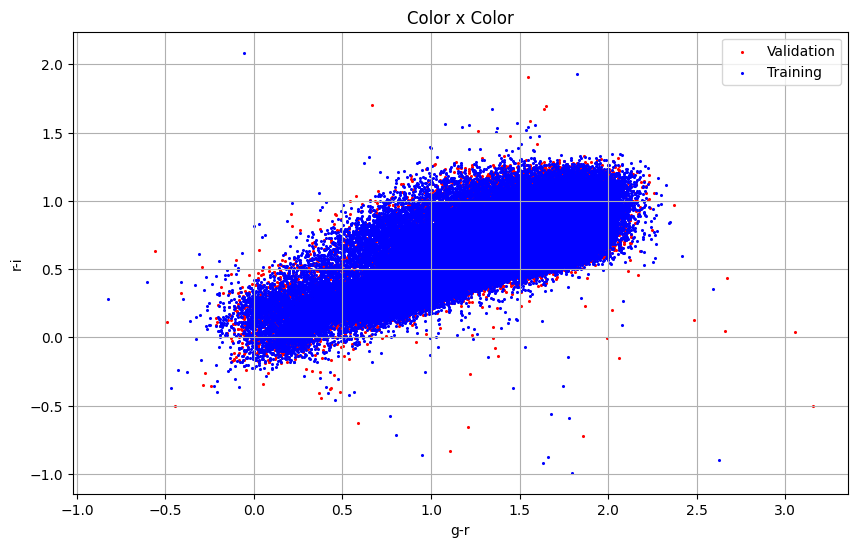

In [78]:
gr_val = validation['mag_auto_g_dered']-validation['mag_auto_r_dered']
ri_val = validation['mag_auto_r_dered']-validation['mag_auto_i_dered']
iz_val = validation['mag_auto_i_dered']-validation['mag_auto_z_dered']
gr_trai = training['mag_auto_g_dered']-training['mag_auto_r_dered']
ri_trai = training['mag_auto_r_dered']-training['mag_auto_i_dered']
iz_trai = training['mag_auto_i_dered']-training['mag_auto_z_dered']

plt.figure(figsize = (10,6))
plt.scatter(gr_val,ri_val,color = 'red', s =1.5, label = 'Validation')
plt.scatter(gr_trai,ri_trai,color = 'blue', s=1.5, label = 'Training')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.legend()
plt.grid()
plt.title('Color x Color')

## Separing 70% for training and 30% for validation

In [318]:
training = pd.DataFrame([])
validation = pd.DataFrame([])
for survey in surveys: 
    obj = new_sample[new_sample['survey']==survey] #choose new or spec _sample
    cut = int(round(0.7*len(obj),1))
    temp1= obj[:cut] #for training
    training = pd.concat([training, temp1], axis = 0)
    temp2= obj[cut:] #for validation
    validation = pd.concat([validation, temp2], axis = 0)

In [319]:
validation

,coadd_object_id,ra,dec,z,err_z,flag_des,survey,flag_survey,mag_auto_g_dered,mag_auto_r_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
531857,1278933642,36.470609,-4.411581,0.7081,99.0,3,VVDS,3.0,23.337078,21.806034,...,20.192995,0.091208,0.028955,0.022758,0.031177,0.057100,1.531044,0.799559,0.476288,0.337193
531860,1278948767,36.396406,-4.576644,0.4912,99.0,3,VVDS,3.0,22.623697,21.631695,...,20.701342,0.044540,0.023641,0.028834,0.041375,0.082112,0.992002,0.370752,0.318373,0.241228
531875,955875029,-25.484649,-0.448609,0.4658,99.0,4,VVDS,4.0,22.202826,20.441116,...,19.471363,0.045714,0.011788,0.010191,0.013005,0.043130,1.761709,0.611237,0.336679,0.021837
531877,955874805,-25.489549,-0.446133,0.3344,99.0,4,VVDS,4.0,22.145588,21.035807,...,20.276981,0.040063,0.017486,0.018841,0.025509,0.078022,1.109781,0.373672,0.302740,0.082413
531879,1278939233,36.456074,-4.478366,0.4279,99.0,4,VVDS,4.0,21.497435,19.755182,...,18.736046,0.024370,0.006788,0.006625,0.009896,0.022730,1.742252,0.578852,0.326807,0.113478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525536,953660595,-26.458455,1.678724,0.4649,99.0,4,VIPERS,4.5,22.607296,20.622499,...,19.549829,0.048908,0.012022,0.010021,0.015412,0.042256,1.984797,0.653671,0.345396,0.073603
525545,948196078,-27.796224,1.977469,0.5585,99.0,3,VIPERS,3.5,21.769747,20.606310,...,19.574589,0.041097,0.018362,0.018638,0.025086,0.078332,1.163437,0.501547,0.286371,0.243803
525579,948974089,-27.582516,1.759035,0.7519,99.0,4,VIPERS,4.5,22.481529,21.266361,...,19.799490,0.053523,0.025565,0.017672,0.026130,0.088368,1.215168,0.884144,0.281487,0.301241
525593,952365598,-27.492545,1.770634,0.4946,99.0,4,VIPERS,4.5,22.823277,20.822206,...,19.763224,0.072677,0.017509,0.014158,0.018220,0.078597,2.001070,0.707937,0.354502,-0.003456


In [320]:
training

,coadd_object_id,ra,dec,z,err_z,flag_des,survey,flag_survey,mag_auto_g_dered,mag_auto_r_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
525686,1394561293,53.187684,-27.725475,0.2449,99.0,4,VVDS,4.0,20.632179,19.475288,...,18.758823,0.011138,0.004855,0.006364,0.008645,0.032600,1.156891,0.427477,0.246414,0.042574
525696,1394565577,52.939979,-27.771028,0.2471,99.0,4,VVDS,4.0,20.451700,19.114616,...,18.311321,0.009616,0.003748,0.004446,0.005851,0.023177,1.337084,0.447536,0.303835,0.051924
525700,1394566727,52.972233,-27.777057,0.1816,99.0,4,VVDS,4.0,22.063702,21.037148,...,20.265871,0.025509,0.012451,0.015500,0.022660,0.079986,1.026554,0.406359,0.236458,0.128460
525722,1394561476,53.120098,-27.732210,0.2135,99.0,4,VVDS,4.0,19.591223,18.404610,...,17.627424,0.006990,0.003108,0.004037,0.005414,0.020759,1.186613,0.416632,0.277132,0.083422
525756,1278922478,36.946117,-4.284310,0.4367,99.0,3,VVDS,3.0,21.663898,20.776014,...,20.157990,0.017231,0.009611,0.012509,0.021382,0.049645,0.887884,0.324369,0.221771,0.071884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510603,1229053555,30.407495,-4.899035,0.5506,99.0,3,VIPERS,3.5,21.901739,20.914352,...,20.273382,0.025712,0.013066,0.016397,0.024359,0.069286,0.987387,0.384068,0.242609,0.014294
510605,1253255693,33.246223,-5.923604,0.5366,99.0,4,VIPERS,4.5,22.140760,20.496628,...,19.321585,0.045696,0.012809,0.010521,0.015315,0.043808,1.644133,0.730291,0.314259,0.130493
510610,1253242499,33.269710,-5.791290,0.6449,99.0,4,VIPERS,4.5,22.183287,21.508642,...,20.808134,0.024247,0.016539,0.019325,0.032517,0.086324,0.674644,0.418657,0.034540,0.247311
510612,1258314233,34.302508,-5.406227,0.5332,99.0,4,VIPERS,4.5,22.545570,20.705769,...,19.530333,0.053933,0.012864,0.012023,0.015567,0.044680,1.839802,0.726797,0.390621,0.058018


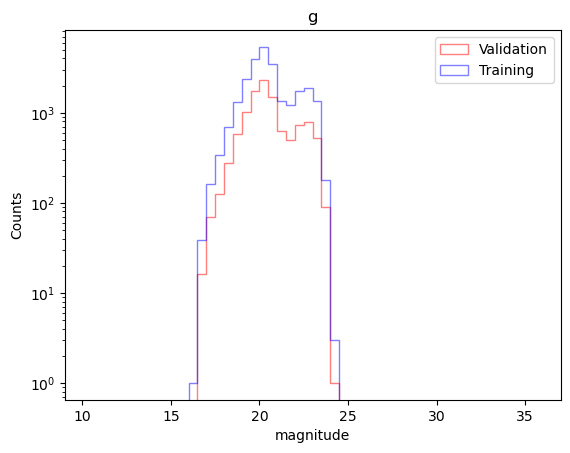

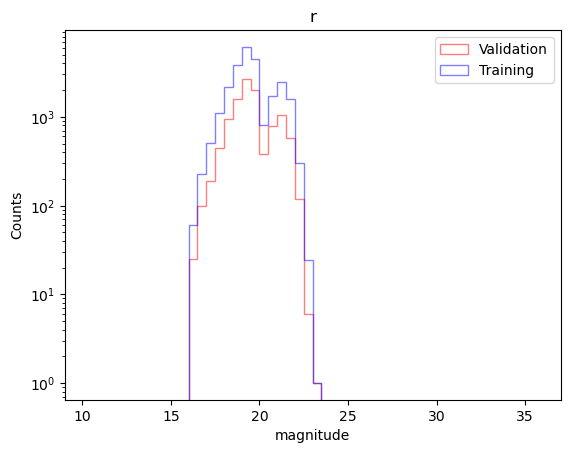

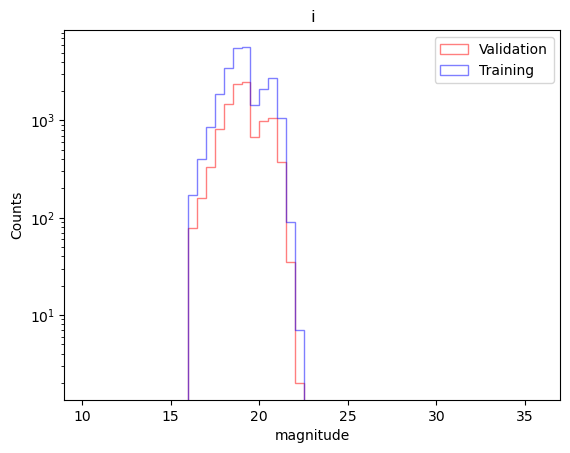

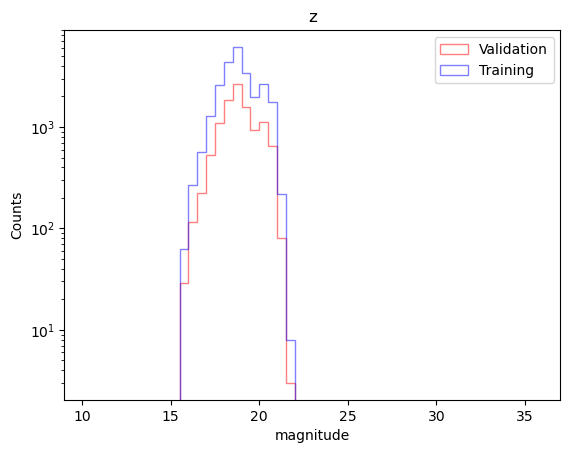

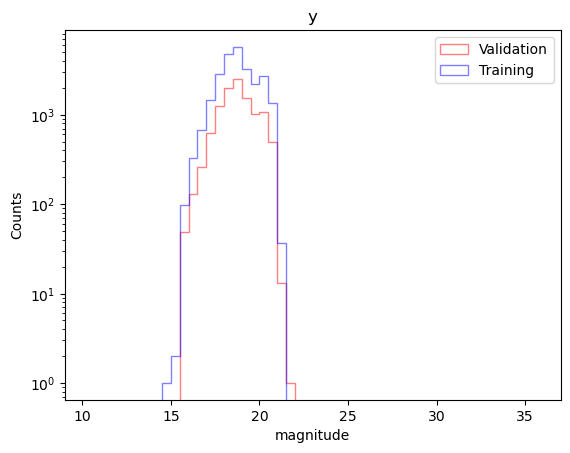

In [321]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(validation[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Validation', alpha = 0.5, edgecolor = "red")
    plt.hist(training[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Training', alpha = 0.5, edgecolor = "blue")
    plt.title(band)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.show()

## Saving the data

In [324]:

del validation['coadd_object_id'], validation['survey'], validation['err_z'], validation['flag_survey'], validation['flag_des'], validation['ra'], validation['dec']
del training['coadd_object_id'], training['survey'], training['err_z'], training['flag_survey'], training['flag_des'], training['ra'], training['dec']


In [325]:
validation.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [326]:
validation['eg-r'] = validation['eg']-validation['er']
validation['er-i'] = validation['er']-validation['ei']
validation['ei-z'] = validation['ei']-validation['ez']
validation['ez-y'] = validation['ez']-validation['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

In [328]:
validation.to_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/validation.GAMA_VIPERS_VVDS.1', sep=' ', index = False)
training.to_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/training.GAMA_VIPERS_VVDS.1', sep=' ', index = False)

In [329]:
validation


,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
531857,0.7081,23.337078,21.806034,21.006475,20.530188,20.192995,0.091208,0.028955,0.022758,0.031177,0.057100,1.531044,0.799559,0.476288,0.337193,0.062253,0.006198,-0.008419,-0.025922
531860,0.4912,22.623697,21.631695,21.260942,20.942570,20.701342,0.044540,0.023641,0.028834,0.041375,0.082112,0.992002,0.370752,0.318373,0.241228,0.020899,-0.005193,-0.012541,-0.040738
531875,0.4658,22.202826,20.441116,19.829880,19.493200,19.471363,0.045714,0.011788,0.010191,0.013005,0.043130,1.761709,0.611237,0.336679,0.021837,0.033926,0.001596,-0.002814,-0.030125
531877,0.3344,22.145588,21.035807,20.662134,20.359394,20.276981,0.040063,0.017486,0.018841,0.025509,0.078022,1.109781,0.373672,0.302740,0.082413,0.022577,-0.001355,-0.006668,-0.052512
531879,0.4279,21.497435,19.755182,19.176331,18.849524,18.736046,0.024370,0.006788,0.006625,0.009896,0.022730,1.742252,0.578852,0.326807,0.113478,0.017582,0.000163,-0.003271,-0.012834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525536,0.4649,22.607296,20.622499,19.968828,19.623432,19.549829,0.048908,0.012022,0.010021,0.015412,0.042256,1.984797,0.653671,0.345396,0.073603,0.036886,0.002002,-0.005391,-0.026845
525545,0.5585,21.769747,20.606310,20.104763,19.818392,19.574589,0.041097,0.018362,0.018638,0.025086,0.078332,1.163437,0.501547,0.286371,0.243803,0.022736,-0.000277,-0.006447,-0.053246
525579,0.7519,22.481529,21.266361,20.382217,20.100731,19.799490,0.053523,0.025565,0.017672,0.026130,0.088368,1.215168,0.884144,0.281487,0.301241,0.027958,0.007892,-0.008458,-0.062238
525593,0.4946,22.823277,20.822206,20.114269,19.759768,19.763224,0.072677,0.017509,0.014158,0.018220,0.078597,2.001070,0.707937,0.354502,-0.003456,0.055168,0.003350,-0.004062,-0.060377


In [330]:
max(validation['#zs'])

1.284

In [331]:
max(training['#zs'])

1.4449